In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import ptemcee

Set up a Gaussian mixture that will test the parallel-tempering a bit.  We would like to sample in the domain $-2 < \theta < 2$ with a flat prior; but to avoid having to deal with the hard boundary, we will use an unconstrained sampling space here, instead of the "box" with $-2 < \theta < 2$.  One simple way to do this is to sample instead in 
$$
\tilde{\theta} \equiv \log\left(2 - \theta\right) - \log\left( \theta + 2 \right).
$$
A prior on $\theta$ becomes a prior 
$$
p\left( \tilde{\theta} \right) = \frac{p\left( \theta\right)}{\partial \tilde{\theta} / \partial \theta} = \frac{p\left( \theta \right)}{\frac{1}{2-\theta} + \frac{1}{\theta + 2}}.
$$
In the likelihood function one simply needs to extract $\theta$ from $\tilde{\theta}$ via the inverse logit:
$$
\theta = \frac{4}{1+\exp\left( - \tilde{\theta} \right)} - 2.
$$
The code below implements this:

In [21]:
def logl_theta(theta):
    mu0 = -1.0
    mu1 = 1.0
    sigma = 0.2

    p0 = -0.5*np.sum(np.square((theta - mu0)/sigma))
    p1 = -0.5*np.sum(np.square((theta - mu1)/sigma))

    return np.logaddexp(p0, p1)

def logl(theta_tilde):
    return logl_theta(4/(1 + np.exp(-theta_tilde)) - 2)

def logp(theta_tilde):
    theta = 4/(1 + np.exp(-theta_tilde)) - 2

    return np.sum(-np.log(1/(2-theta) + 1/(2+theta)))

Because the code above will work in any dimension, let's plot it in one dimesion:

Text(0, 0.5, '$\\mathcal{L}$')

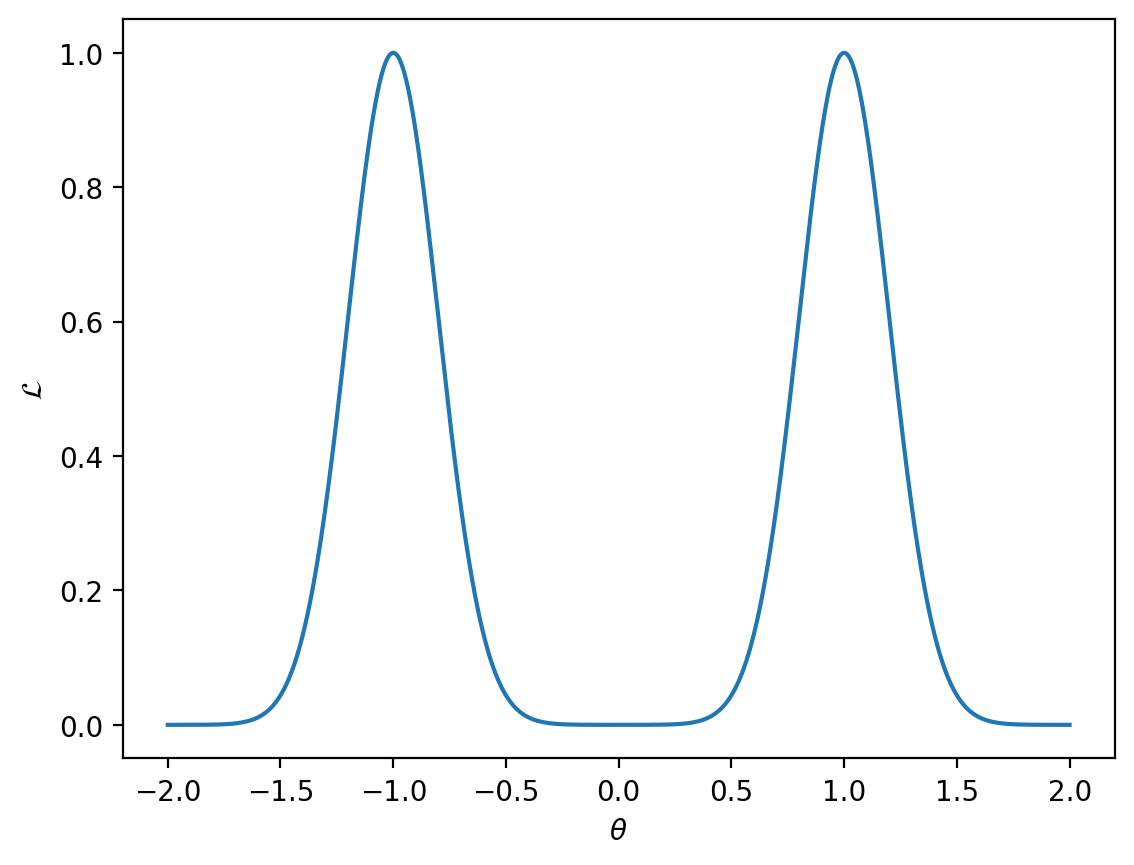

In [10]:
xs = np.linspace(-2, 2, 1024)
plt.plot(xs, [np.exp(logl_theta(x)) for x in xs])
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\mathcal{L}$')

In the un-constrained space, we have 

Text(0, 0.5, '$\\mathcal{L}$')

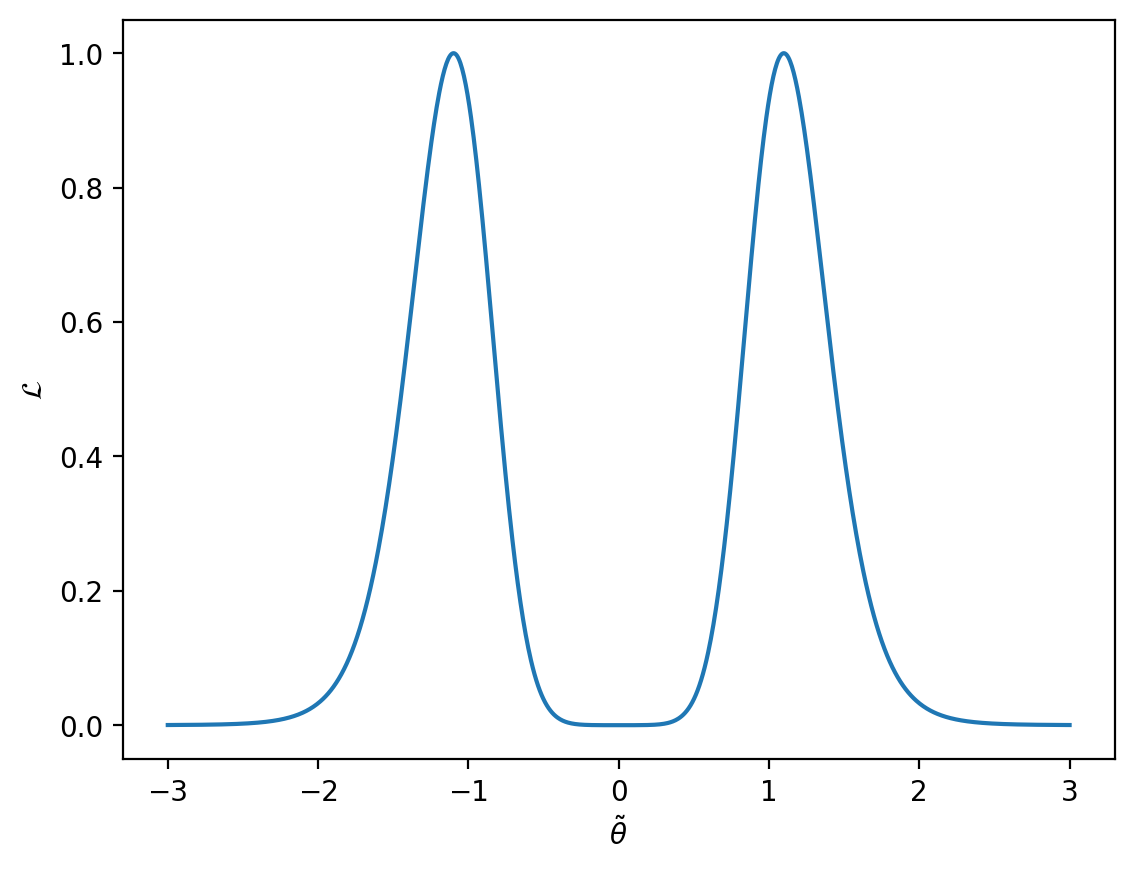

In [16]:
xs = np.linspace(-3, 3, 1024)
plt.plot(xs, [np.exp(logl(x)) for x in xs])
plt.xlabel(r'$\tilde{\theta}$')
plt.ylabel(r'$\mathcal{L}$')

For the sampling, we will use five dimensions because, well, why not.

In [22]:
ndim = 5
nwalkers = 16 # must be 2*ndim + 1 at least
ntemps = 8 

# To avoid a bug with the numpy version we are using, we need to monkey patch `np.float` to `np.float64`
np.float = np.float64

sampler = ptemcee.Sampler(nwalkers, ndim, logl, logp, ntemps=8)

Set up the initial state:

In [31]:
p0 = np.random.randn(ntemps, nwalkers, ndim)

In [32]:
nmcmc = 128
nthin = 1
sampler.run_mcmc(p0, nmcmc, nthin, adapt=True)

(array([[[ 1.20473653e+00,  7.73046520e-01,  1.12508753e+00,
           7.93566254e-01,  1.51729819e+00],
         [ 1.11680197e+00,  1.13933120e+00,  1.10572779e+00,
           1.13599527e+00,  1.20686855e+00],
         [-7.92861440e-01, -1.42803279e+00, -1.45720127e+00,
          -7.33357995e-01, -7.06688469e-01],
         [-8.51340486e-01, -1.42653669e+00, -1.30500578e+00,
          -1.08442766e+00, -9.35537856e-01],
         [ 1.45737268e+00,  1.88983715e+00,  1.15632022e+00,
           1.22499713e+00,  8.16455499e-01],
         [-7.27124774e-01, -1.54770202e+00, -9.03654106e-01,
          -8.37607493e-01, -1.19818661e+00],
         [-1.18351162e+00, -1.17196916e+00, -1.43661506e+00,
          -8.45435372e-01, -8.78999604e-01],
         [-1.42523154e+00, -1.32719825e+00, -1.27982030e+00,
          -1.58330990e+00, -1.13208620e+00],
         [-8.46758389e-01, -1.11327695e+00, -1.14675179e+00,
          -9.61623325e-01, -7.16534993e-01],
         [ 1.24571436e+00,  1.13702685e+00,  1

Let's check whether the average log-likelihood of the zero-temperature chain has converged:

Text(0, 0.5, '$\\left\\langle \\mathcal{L} \\right\\rangle$')

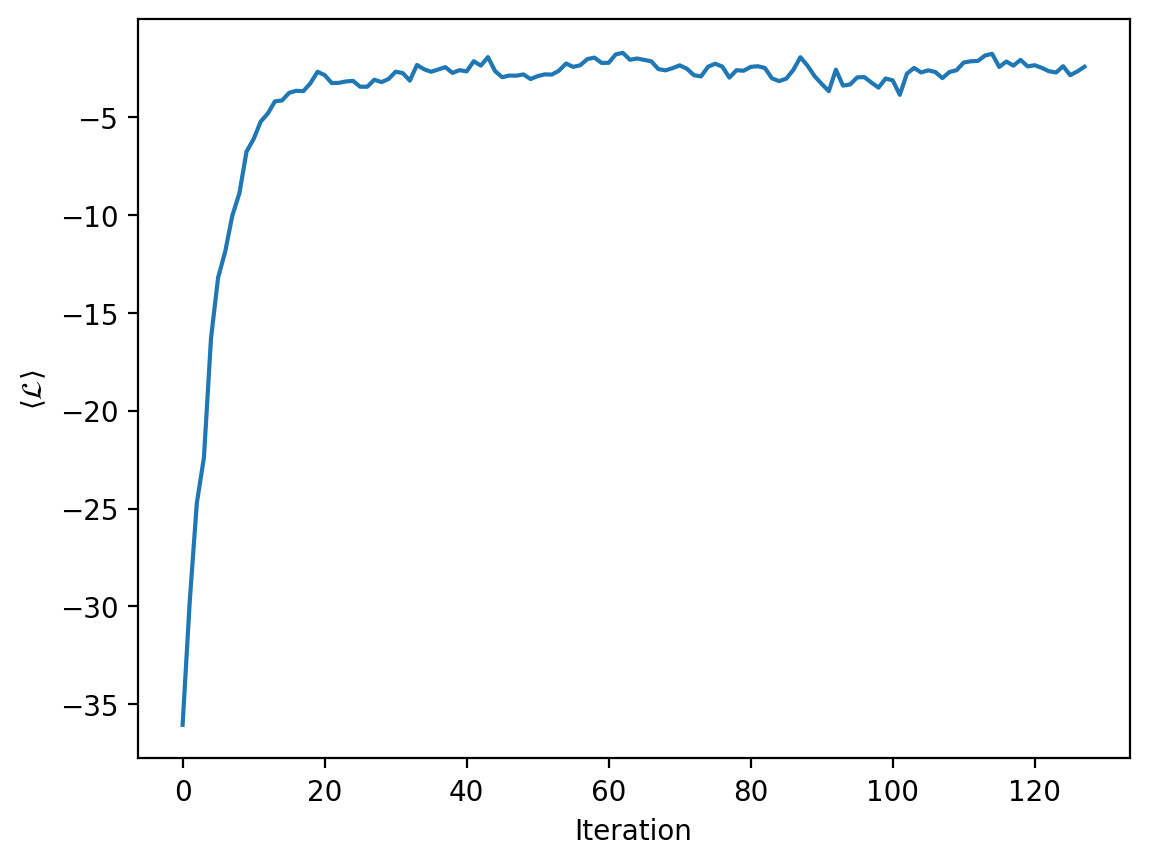

In [33]:
plt.plot(np.mean(sampler.loglikelihood[0, :, :], axis=0))
plt.xlabel('Iteration')
plt.ylabel(r'$\left\langle \mathcal{L} \right\rangle$')

This looks reasonably converged; let's reset the sampler, and run for a lot of steps, and see what we get (saving the current state, ofc):

In [34]:
sampler.chain.shape

(8, 16, 128, 5)

In [37]:
p0 = sampler.chain[:,:,-1,:]  # Dims are temps, walkers, iterations, parameter dimensions
sampler.reset()

Now we run to get 1024 samples out, thinning by 16:

In [38]:
sampler.run_mcmc(p0, 1024, 16, adapt=True)

(array([[[ 9.22523527e-01,  8.87787250e-01,  1.51154480e+00,
           1.25686874e+00,  1.26043163e+00],
         [-1.08402640e+00, -1.44750343e+00, -1.27631187e+00,
          -1.46051941e+00, -9.58683598e-01],
         [ 1.02112288e+00,  8.53342373e-01,  1.36624942e+00,
           1.56781988e+00,  6.53494834e-01],
         [-1.23315195e+00, -1.17118510e+00, -1.23273890e+00,
          -1.41801132e+00, -6.72152087e-01],
         [ 8.49491684e-01,  1.33387904e+00,  1.34835859e+00,
           1.09280121e+00,  1.26693964e+00],
         [ 1.05087923e+00,  1.45203604e+00,  1.27094244e+00,
           1.10385251e+00,  1.10492147e+00],
         [ 1.71780171e+00,  1.09860407e+00,  1.42549717e+00,
           9.15475833e-01,  1.10867289e+00],
         [-9.94176653e-01, -9.78377091e-01, -1.71817755e+00,
          -8.92146159e-01, -9.81416541e-01],
         [-9.85420011e-01, -1.89095855e+00, -8.62166301e-01,
          -1.44158337e+00, -1.02797253e+00],
         [-1.60498966e+00, -1.04837271e+00, -1

Again, plotting the log-likelihoods:

Text(0, 0.5, '$\\left\\langle \\mathcal{L} \\right\\rangle$')

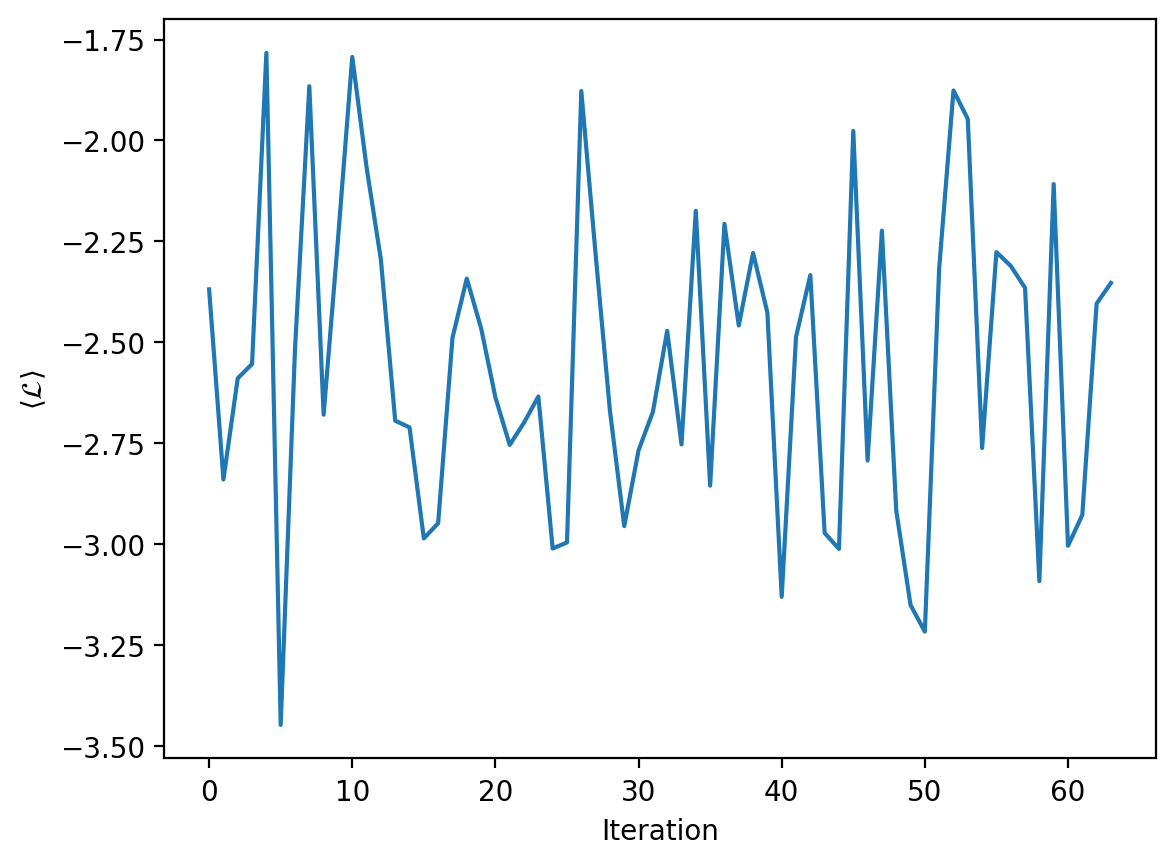

In [39]:
plt.plot(np.mean(sampler.loglikelihood[0, :, :], axis=0))
plt.xlabel('Iteration')
plt.ylabel(r'$\left\langle \mathcal{L} \right\rangle$')

If you want to see the evolution of the adapting temperatures (they don't evolve much here):

Text(0, 0.5, '$\\beta$')

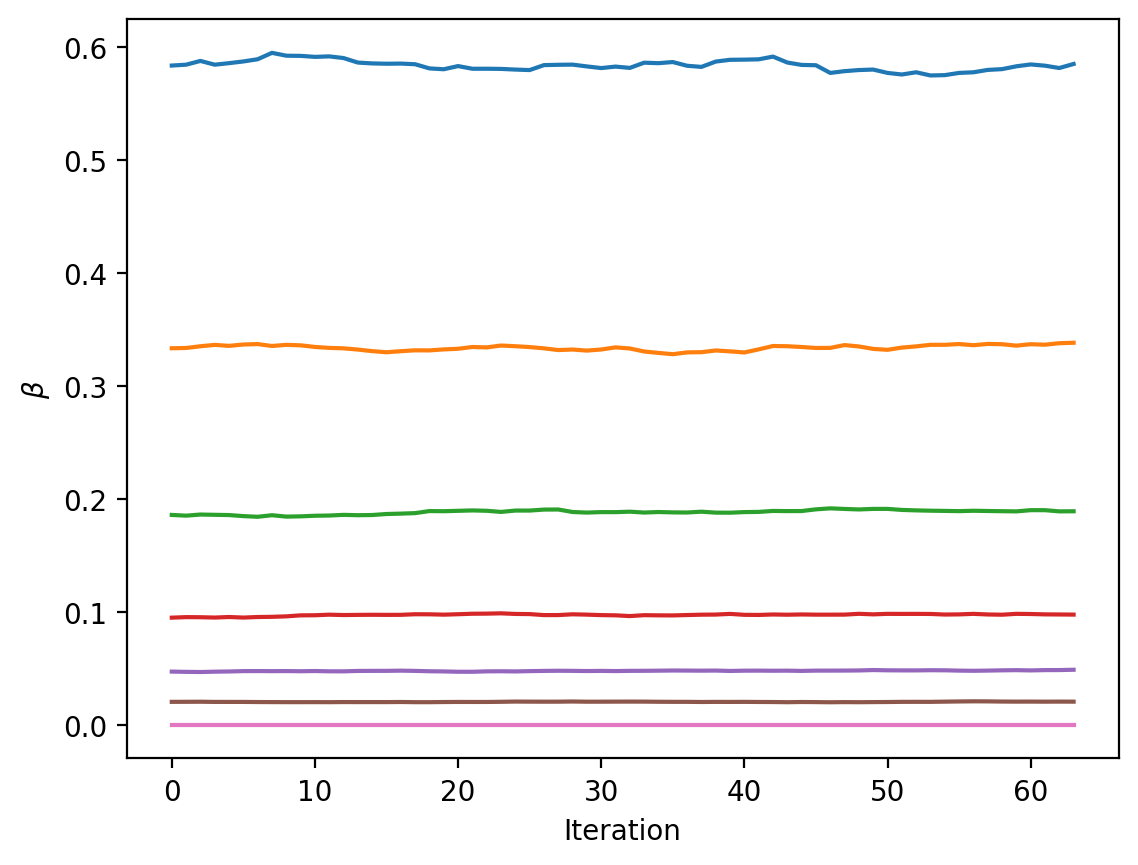

In [44]:
for i in range(1, ntemps):
    plt.plot(sampler.beta_history[i,:])
plt.xlabel('Iteration')
plt.ylabel(r'$\beta$')

As you can see, the temperature ladder is dense enough that lots of temperature swaps are accepted:

In [45]:
sampler.tswap_acceptance_fraction

array([0.55926514, 0.5597229 , 0.56170654, 0.5642395 , 0.56716919,
       0.57177734, 0.57437134, 0.57427979])

Here is a histogram of one coordinate of the chain at the various temperatures.  You can see that at $\beta = 1/T = 1$, the density is the double-peaked one we are seeking; but as $\beta$ shrinks and the temperature rises, this goes over to a uni-modal prior.  This is the magic of parallel-tempering at merging modes of the posterior and allowing for transitions between them.

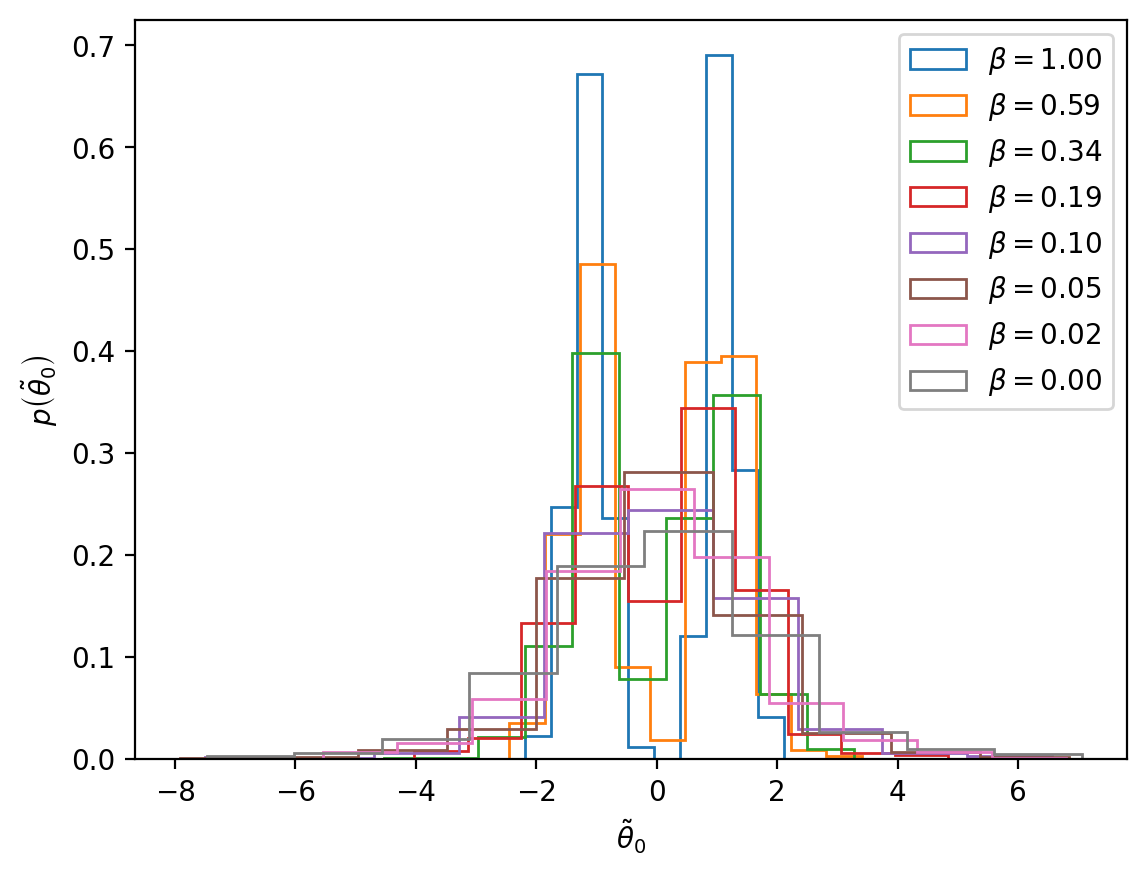

In [52]:
for ibeta in range(ntemps):
    plt.hist(sampler.chain[ibeta, :, :, 0].flatten(), density=True, histtype='step', label=r'$\beta = {:.02f}$'.format(sampler.betas[ibeta]))
plt.xlabel(r'$\tilde{\theta}_0$')
plt.ylabel(r'$p\left( \tilde{\theta}_0 \right)$')
plt.legend(loc='best')

We should plot the posterior in $\theta$, at least for the $\beta = 1$ chain:

Text(0, 0.5, '$p\\left( \\theta_0 \\right)$')

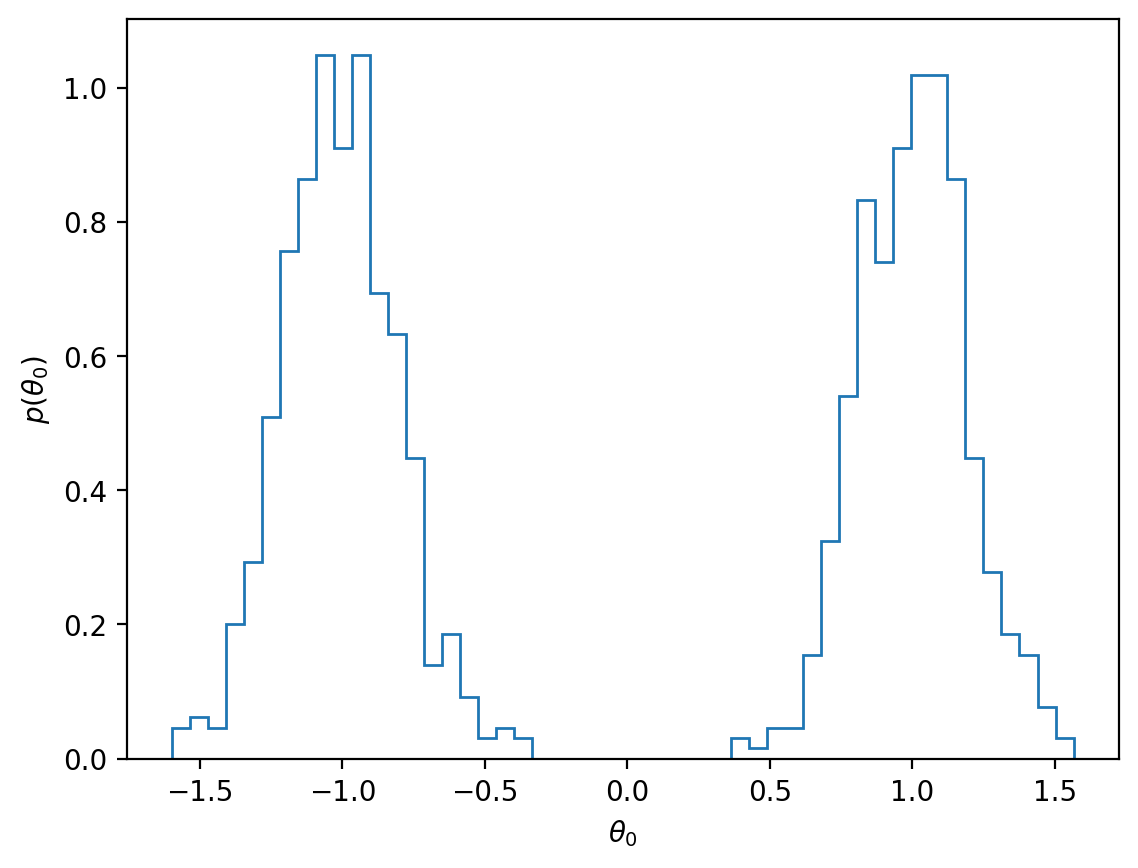

In [55]:
tts = sampler.chain[0, :, :, 0].flatten()
thetas = 4/(1 + np.exp(-tts)) - 2
plt.hist(thetas, density=True, histtype='step', bins=50)
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$p\left( \theta_0 \right)$')